# 라이브러리 불러오기

In [243]:
from glob import glob 
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import folium

# 데이터 불러오기

In [244]:
glob('data/*.csv')

['data/test.csv', 'data/train.csv', 'data/sample_submission.csv']

In [245]:
train = pd.read_csv(glob('data/*.csv')[1])
test = pd.read_csv(glob('data/*.csv')[0])
submission = pd.read_csv(glob('data/*.csv')[2])

In [246]:
test = test.set_index('ID')
train = train.set_index('ID')
submission = submission.set_index('ID')

# 데이터 살펴보기

칼럼 설명
- ID : 샘플 별 고유 id
- Exercise_Duration  : 운동 시간(분)
- Body_Temperature(F) : 체온
- BPM : 심박수
- Height(Feet) : 키(피트)
- Height(Remainder_Inches) : 키(피트 계산 후 더해야 할 키)
- Weight(lb) : 몸무게(파운드)
- Weight_Status : 체중 상태
- Gender : 성별
- Age : 나이
- Calories_Burned : 칼로리 소모량(목표 예측값)

In [247]:
train.head()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
ID,,,,,,,,,,
TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0


## 결측치 확인

In [248]:
# 결측치 없음 
train.isnull().sum()

Exercise_Duration           0
Body_Temperature(F)         0
BPM                         0
Height(Feet)                0
Height(Remainder_Inches)    0
Weight(lb)                  0
Weight_Status               0
Gender                      0
Age                         0
Calories_Burned             0
dtype: int64

In [249]:
# 결측치 없음 
test.isnull().sum()

Exercise_Duration           0
Body_Temperature(F)         0
BPM                         0
Height(Feet)                0
Height(Remainder_Inches)    0
Weight(lb)                  0
Weight_Status               0
Gender                      0
Age                         0
dtype: int64

## 이상치 확인

In [250]:
train.describe()

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Age,Calories_Burned
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,104.033573,95.498133,5.248800,5.717600,165.361187,42.636000,89.373467
std,8.3553,1.412845,9.587331,0.556663,3.497315,33.308136,16.883188,62.817086
min,1.0000,98.800000,69.000000,4.000000,0.000000,79.400000,20.000000,1.000000
25%,8.0000,103.300000,88.000000,5.000000,3.000000,138.900000,28.000000,35.000000
50%,15.0000,104.400000,95.000000,5.000000,6.000000,163.100000,39.000000,77.000000
75%,23.0000,105.100000,103.000000,6.000000,9.000000,191.800000,56.000000,138.000000
max,30.0000,106.700000,128.000000,7.000000,12.000000,291.000000,79.000000,300.000000


In [251]:
train.describe(include='O')

,Weight_Status,Gender
count,7500,7500
unique,3,2
top,Normal Weight,F
freq,4681,3769


<Axes: >

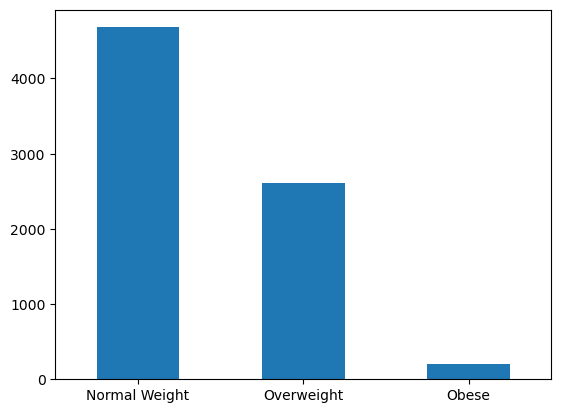

In [252]:
# Obese가 현저히 적음
train['Weight_Status'].value_counts().plot.bar(rot=0)

In [253]:
train['Weight_Status'].value_counts(1)

Normal Weight    0.624133
Overweight       0.348533
Obese            0.027333
Name: Weight_Status, dtype: float64

<Axes: >

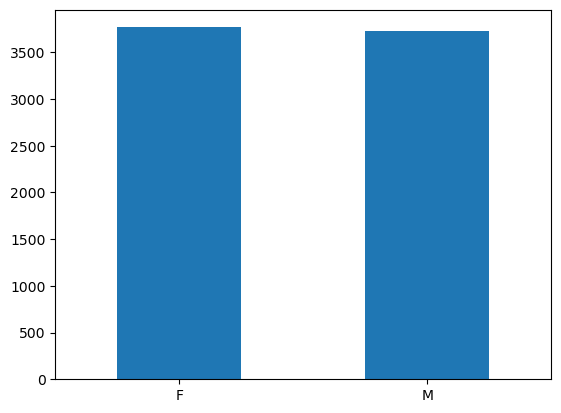

In [254]:
train['Gender'].value_counts().plot.bar(rot=0)

# 피처 엔지니어링

In [255]:
train.head(2)

,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
ID,,,,,,,,,,
TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0


- 두 키 변수를 합해서 하나의 변수로 만들어 준다. 

In [256]:
# ft, inch column을 하나의 cm 컬럼으로 변경해줌 
train['Height(cm)'] = train['Height(Feet)'] * 30.48 + train['Height(Remainder_Inches)']*2.54
test['Height(cm)'] = test['Height(Feet)'] * 30.48 + test['Height(Remainder_Inches)']*2.54

In [257]:
# 기존 ft, inch column은 삭제 
train = train.drop(columns=['Height(Feet)','Height(Remainder_Inches)'])
test = test.drop(columns=['Height(Feet)','Height(Remainder_Inches)'])

- 몸무게와 몸의 온도를 kg, 섭씨로 바꿔준다. 

In [258]:
train['Weight(kg)'] = train['Weight(lb)'] * 0.45359237
test['Weight(kg)'] = test['Weight(lb)'] * 0.45359237

train['Body_Temperature(C)'] = (train['Body_Temperature(F)'] - 32)*(5/9)
test['Body_Temperature(C)'] = (test['Body_Temperature(F)'] - 32)*(5/9)

# drop
train = train.drop(columns=['Weight(lb)','Body_Temperature(F)'])
test = test.drop(columns=['Weight(lb)','Body_Temperature(F)'])

In [259]:
train

,Exercise_Duration,BPM,Weight_Status,Gender,Age,Calories_Burned,Height(cm),Weight(kg),Body_Temperature(C)
ID,,,,,,,,,
TRAIN_0000,26.0,107.0,Normal Weight,F,45,166.0,175.26,69.989303,40.888889
TRAIN_0001,7.0,88.0,Overweight,M,50,33.0,198.12,102.012924,39.611111
TRAIN_0002,7.0,86.0,Overweight,M,29,23.0,190.50,99.019214,39.611111
TRAIN_0003,17.0,99.0,Normal Weight,F,33,91.0,167.64,66.995593,40.000000
TRAIN_0004,9.0,88.0,Normal Weight,M,38,32.0,177.80,77.019984,39.277778
...,...,...,...,...,...,...,...,...,...
TRAIN_7495,22.0,104.0,Normal Weight,F,75,151.0,147.32,50.983782,40.611111
TRAIN_7496,20.0,104.0,Normal Weight,F,21,114.0,172.72,66.995593,40.722222
TRAIN_7497,8.0,90.0,Overweight,M,57,41.0,187.96,91.988533,39.500000


- 2가지 categorical value인 Gender와 Weight_status를 인코딩 해준다. 
- Gender는 비율이 50대 50이므로 label encoding 
- Weight_status 비율이 고르지 못하므로 One-Hot Encoding을 적용한다. 

In [260]:
# Label Encoding 
# Train 데이터 
train.loc[train['Gender'] == 'F', 'Gender'] = 0
train.loc[train['Gender'] == 'M', 'Gender'] = 1

# Test 데이터 
test.loc[test['Gender'] == 'F', 'Gender'] = 0
test.loc[test['Gender'] == 'M', 'Gender'] = 1

In [261]:
# dtype 변경해 주기 
train['Gender'] = train['Gender'].astype('int')
test['Gender'] = test['Gender'].astype('int')

In [262]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [263]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7500 entries, TRAIN_0000 to TRAIN_7499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Exercise_Duration            7500 non-null   float64
 1   BPM                          7500 non-null   float64
 2   Gender                       7500 non-null   int64  
 3   Age                          7500 non-null   int64  
 4   Calories_Burned              7500 non-null   float64
 5   Height(cm)                   7500 non-null   float64
 6   Weight(kg)                   7500 non-null   float64
 7   Body_Temperature(C)          7500 non-null   float64
 8   Weight_Status_Normal Weight  7500 non-null   uint8  
 9   Weight_Status_Obese          7500 non-null   uint8  
 10  Weight_Status_Overweight     7500 non-null   uint8  
dtypes: float64(6), int64(2), uint8(3)
memory usage: 549.3+ KB


In [264]:
test.head(2)

,Exercise_Duration,BPM,Gender,Age,Height(cm),Weight(kg),Body_Temperature(C),Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight
ID,,,,,,,,,,
TEST_0000,26.0,107.0,0,45,154.94,51.981686,40.611111,1,0,0
TEST_0001,29.0,111.0,1,21,187.96,89.992726,40.500000,0,0,1


# 데이터 시각화

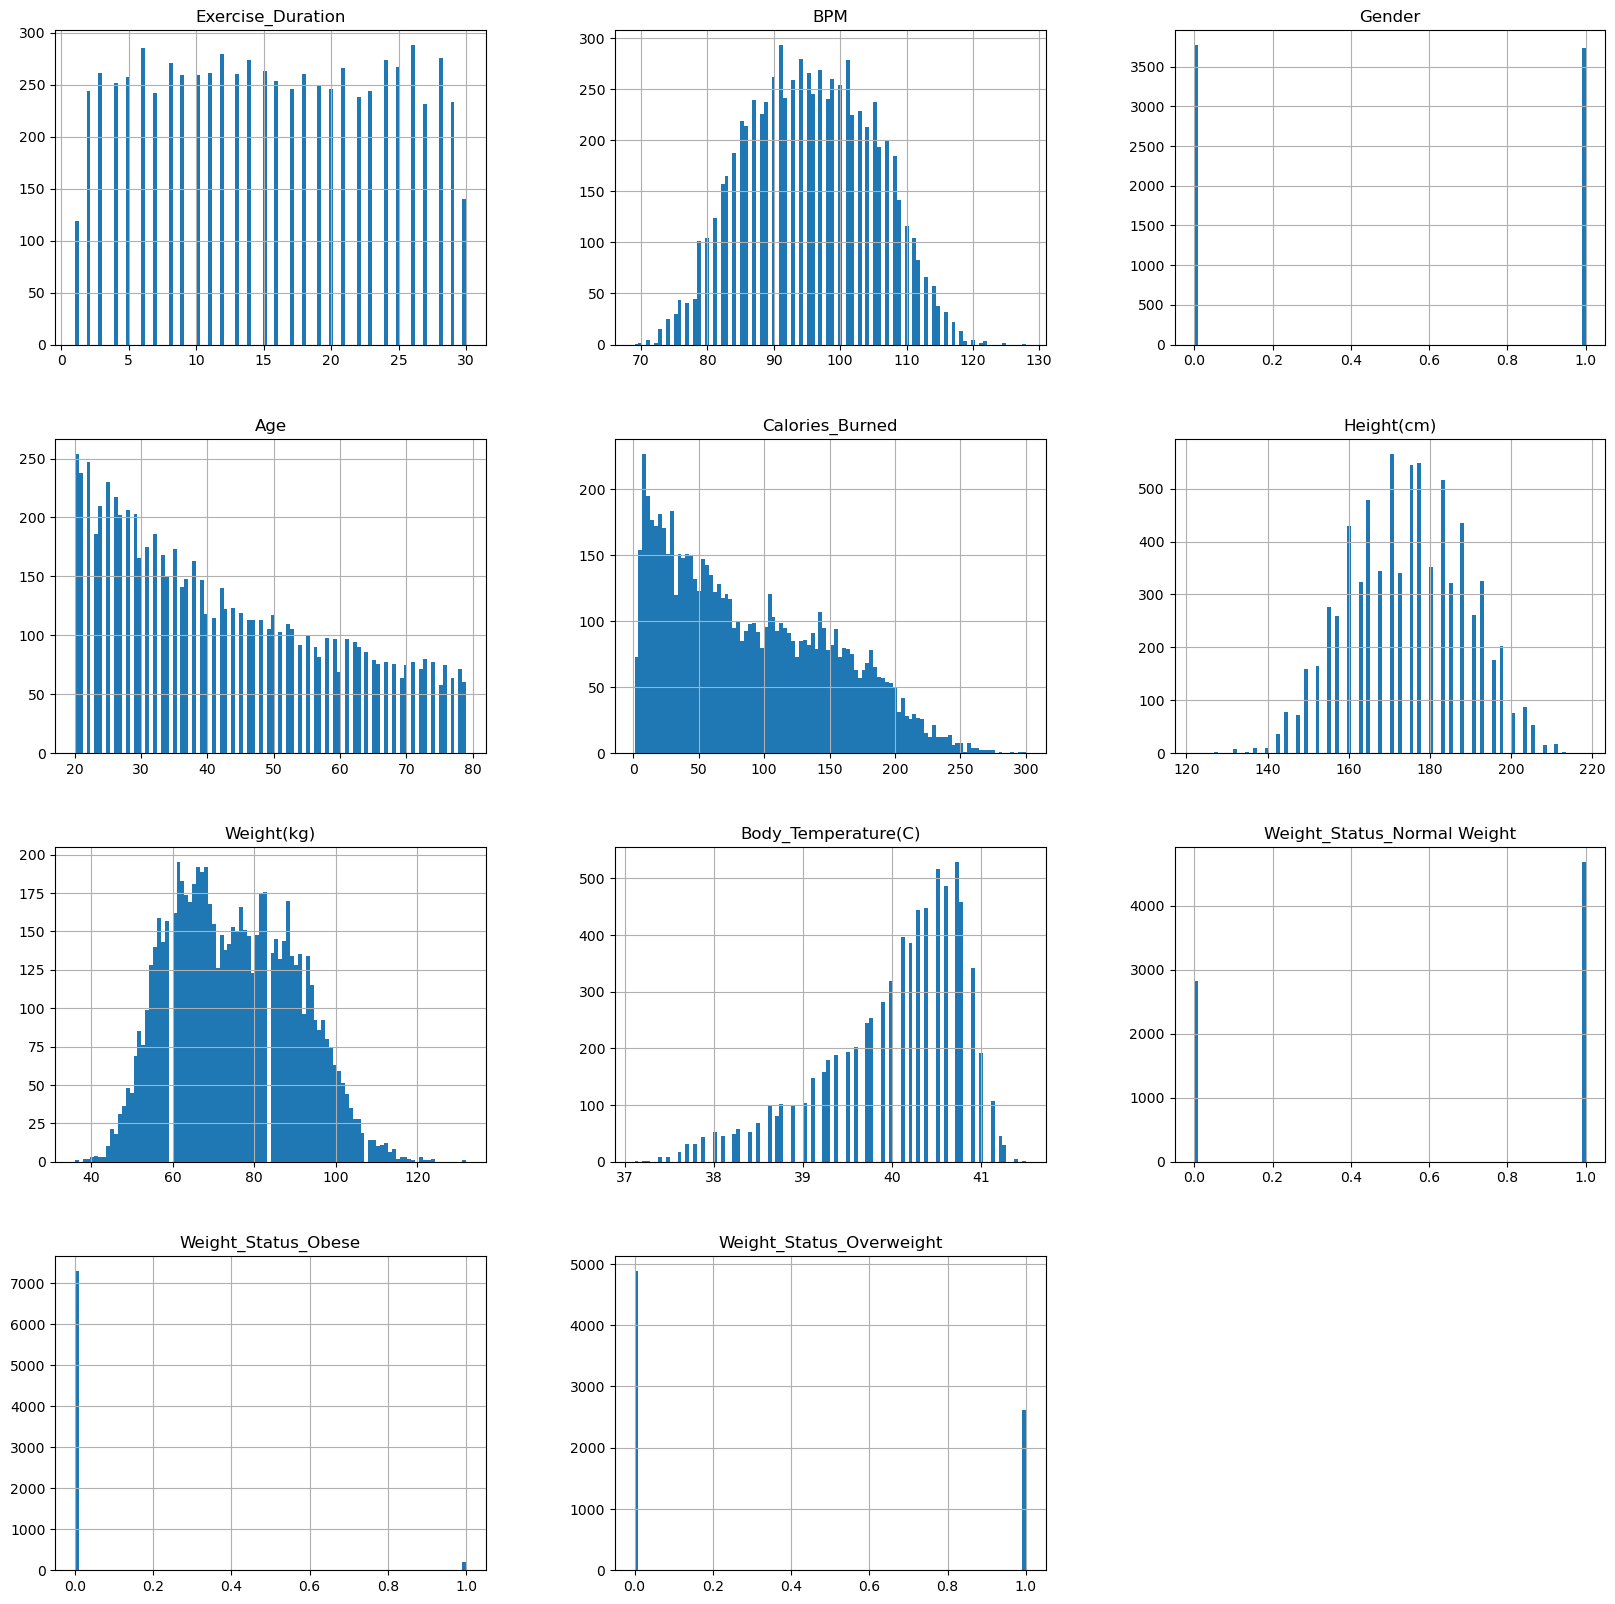

In [265]:
train.hist(bins=100,figsize=(20,20));

In [266]:
train['Body_Temperature(C)'].describe()

count    7500.000000
mean       40.018652
std         0.784914
min        37.111111
25%        39.611111
50%        40.222222
75%        40.611111
max        41.500000
Name: Body_Temperature(C), dtype: float64

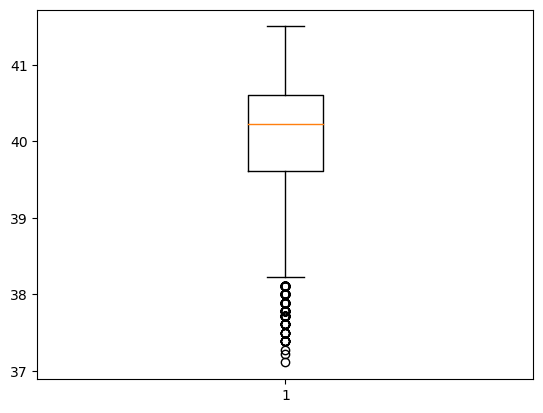

In [267]:
# 몇 개의 낮은 온도의 Outlier가 보입니다. 
plt.boxplot(train['Body_Temperature(C)']);

In [268]:
train['BPM'].describe()

count    7500.000000
mean       95.498133
std         9.587331
min        69.000000
25%        88.000000
50%        95.000000
75%       103.000000
max       128.000000
Name: BPM, dtype: float64

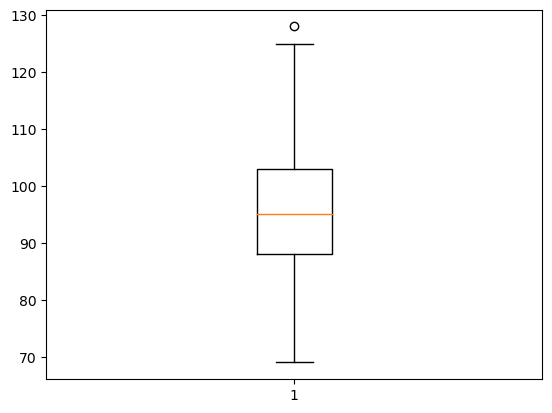

In [269]:
# 심박도 Outlier가 하나 있습니다. 
plt.boxplot(train['BPM']);

In [270]:
train['Weight(kg)'].describe()

count    7500.000000
mean       75.006573
std        15.108316
min        36.015234
25%        63.003980
50%        73.980916
75%        86.999017
max       131.995380
Name: Weight(kg), dtype: float64

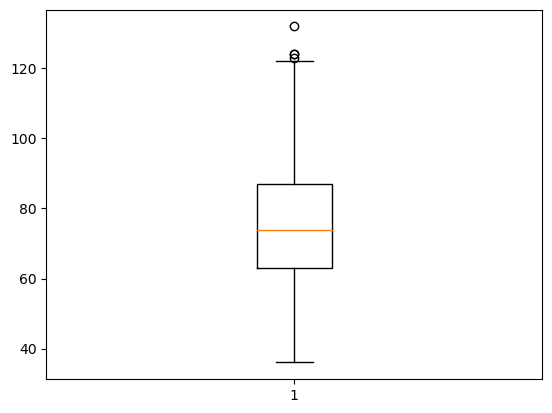

In [271]:
# 몇 개의 몸무게 outlier가 있습니다. 
plt.boxplot(train['Weight(kg)']);

In [272]:
train.describe()

,Exercise_Duration,BPM,Gender,Age,Calories_Burned,Height(cm),Weight(kg),Body_Temperature(C),Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,95.498133,0.497467,42.636000,89.373467,174.506128,75.006573,40.018652,0.624133,0.027333,0.348533
std,8.3553,9.587331,0.500027,16.883188,62.817086,14.318365,15.108316,0.784914,0.484378,0.163064,0.476538
min,1.0000,69.000000,0.000000,20.000000,1.000000,121.920000,36.015234,37.111111,0.000000,0.000000,0.000000
25%,8.0000,88.000000,0.000000,28.000000,35.000000,165.100000,63.003980,39.611111,0.000000,0.000000,0.000000
50%,15.0000,95.000000,0.000000,39.000000,77.000000,175.260000,73.980916,40.222222,1.000000,0.000000,0.000000
75%,23.0000,103.000000,1.000000,56.000000,138.000000,185.420000,86.999017,40.611111,1.000000,0.000000,1.000000
max,30.0000,128.000000,1.000000,79.000000,300.000000,218.440000,131.995380,41.500000,1.000000,1.000000,1.000000


- bmi 공식 : BMI = kg/m2
- overweight은 BMI 25~30 사이 
- obese는 그 이상 

In [273]:
q1 = np.percentile(train['Weight(kg)'], 25)
q3 = np.percentile(train['Weight(kg)'], 75)
iqr = q3 - q1
weight_check = train.loc[train['Weight(kg)'] > q3 + iqr * 1.5,:].copy()
weight_check

,Exercise_Duration,BPM,Gender,Age,Calories_Burned,Height(cm),Weight(kg),Body_Temperature(C),Weight_Status_Normal Weight,Weight_Status_Obese,Weight_Status_Overweight
ID,,,,,,,,,,,
TRAIN_1672,16.0,87.0,1,67,94.0,210.82,124.012154,40.111111,0,0,1
TRAIN_2227,1.0,88.0,1,40,5.0,218.44,131.995380,37.777778,0,0,1
TRAIN_2457,17.0,103.0,1,43,121.0,213.36,124.012154,40.722222,0,0,1
TRAIN_4889,25.0,103.0,1,74,215.0,210.82,123.014251,40.777778,0,0,1


In [274]:
# overweight 맞음. 키가 많이 커서 몸무게가 많이 나가도 상관 x 
weight_check['Weight(kg)']/np.square((weight_check['Height(cm)']/100))

ID
TRAIN_1672    27.902340
TRAIN_2227    27.662689
TRAIN_2457    27.241953
TRAIN_4889    27.677815
dtype: float64

## 상관계수 분석

In [275]:
# 인코딩된 컬럼을 제외하고 상관계수 분석 
correlation = train[['Exercise_Duration', 'BPM', 'Age','Height(cm)',
                     'Weight(kg)', 'Body_Temperature(C)', 'Calories_Burned']].corr()

<Axes: >

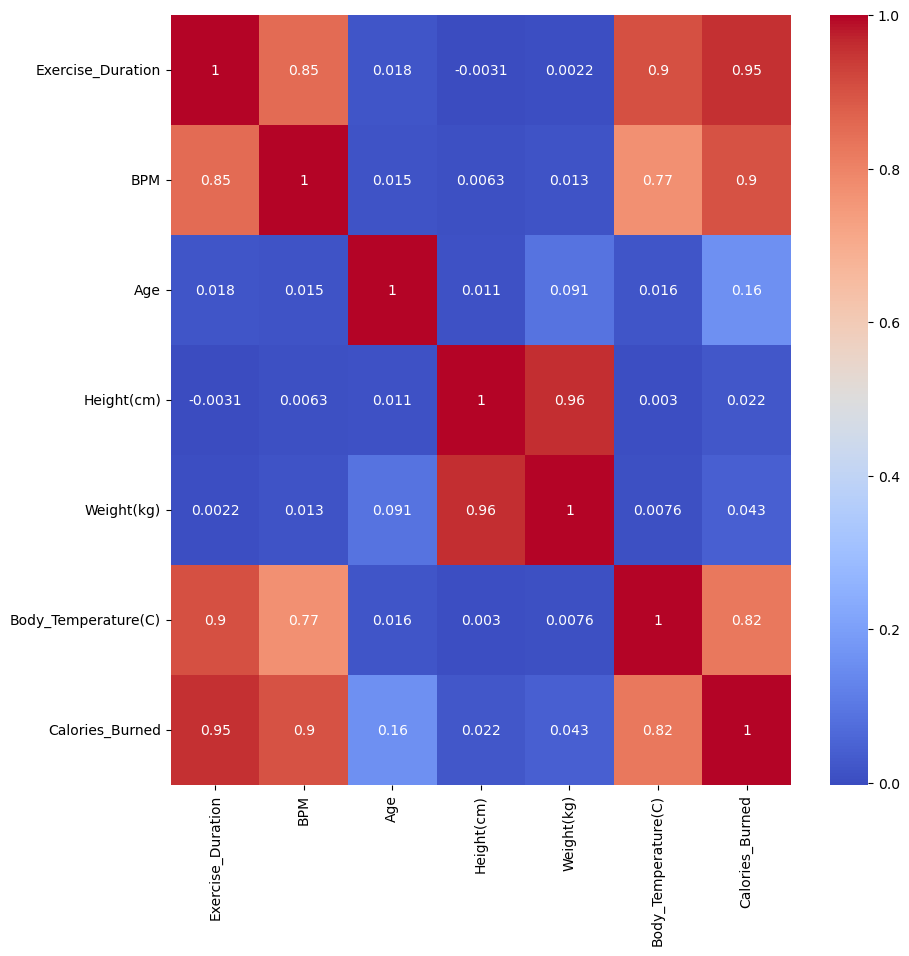

In [276]:
plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

## 머신러닝 - Catboost 

In [277]:
X = train.drop(columns=['Calories_Burned'])
y = train['Calories_Burned']

In [278]:
# from sklearn.model_selection import train_test_split

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

In [283]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(loss_function='RMSE', depth=6, iterations=1000, l2_leaf_reg=1, learning_rate=0.1) 

In [284]:
grid = {'iterations': [100, 500, 1000],
        'learning_rate': [0.01, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

In [285]:
# # cv_result 에서 rank 를 일관되게 표현할 수 있습니다. 
# from sklearn.model_selection import GridSearchCV

# reg = GridSearchCV(model, grid, n_jobs=-1, cv=3, verbose=2, 
#                    scoring="neg_root_mean_squared_error")
# reg.fit(X, y)

In [286]:
pd.DataFrame(reg.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_depth,param_iterations,param_l2_leaf_reg,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
69,2.401092,0.301239,0.013605,0.000724,6,1000,1,0.1,"{'depth': 6, 'iterations': 1000, 'l2_leaf_reg'...",-1.144152,-0.877527,-0.882134,-0.967938,0.124617,1
67,2.511436,0.068859,0.029332,0.011075,6,1000,0.5,0.1,"{'depth': 6, 'iterations': 1000, 'l2_leaf_reg'...",-1.190739,-0.858776,-0.867378,-0.972298,0.154501,2
65,2.196130,0.371033,0.033049,0.018959,6,1000,0.2,0.1,"{'depth': 6, 'iterations': 1000, 'l2_leaf_reg'...",-1.211474,-0.859778,-0.873232,-0.981495,0.162713,3
71,2.075472,0.115269,0.025141,0.006822,6,1000,3,0.1,"{'depth': 6, 'iterations': 1000, 'l2_leaf_reg'...",-1.149547,-0.924546,-0.897071,-0.990388,0.113100,4
43,2.467323,0.266588,0.048287,0.002616,4,1000,0.5,0.1,"{'depth': 4, 'iterations': 1000, 'l2_leaf_reg'...",-1.179195,-0.993886,-0.980234,-1.051105,0.090745,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,0.300577,0.020890,0.079900,0.057450,4,100,3,0.01,"{'depth': 4, 'iterations': 100, 'l2_leaf_reg':...",-28.350447,-27.121206,-28.026360,-27.832671,0.520189,92
0,0.194265,0.004715,0.006462,0.001214,2,100,0.2,0.01,"{'depth': 2, 'iterations': 100, 'l2_leaf_reg':...",-31.496843,-30.091297,-31.112195,-30.900112,0.593085,93
4,0.080897,0.002798,0.013680,0.001336,2,100,1,0.01,"{'depth': 2, 'iterations': 100, 'l2_leaf_reg':...",-31.501992,-30.099438,-31.108407,-30.903279,0.590676,94
2,0.170986,0.040991,0.011778,0.006771,2,100,0.5,0.01,"{'depth': 2, 'iterations': 100, 'l2_leaf_reg':...",-31.543897,-30.093011,-31.101676,-30.912861,0.607182,95


In [287]:
y_predict = model.fit(X_train, y_train).predict(X_test)
y_predict = np.expm1(y_predict)
y_predict[:5]

0:	learn: 57.1235543	total: 3.12ms	remaining: 3.11s
1:	learn: 52.0758061	total: 4.71ms	remaining: 2.35s
2:	learn: 47.5730894	total: 5.97ms	remaining: 1.98s
3:	learn: 43.3146682	total: 7.46ms	remaining: 1.86s
4:	learn: 39.6441164	total: 8.76ms	remaining: 1.74s
5:	learn: 36.1197922	total: 9.91ms	remaining: 1.64s
6:	learn: 33.0802696	total: 11ms	remaining: 1.56s
7:	learn: 30.2596554	total: 12.3ms	remaining: 1.53s
8:	learn: 27.7784420	total: 13.5ms	remaining: 1.49s
9:	learn: 25.4963752	total: 14.8ms	remaining: 1.47s
10:	learn: 23.4549645	total: 16.3ms	remaining: 1.47s
11:	learn: 21.6096038	total: 17.8ms	remaining: 1.47s
12:	learn: 19.9159367	total: 21.1ms	remaining: 1.6s
13:	learn: 18.3649733	total: 22.7ms	remaining: 1.6s
14:	learn: 17.0274735	total: 24ms	remaining: 1.58s
15:	learn: 15.7983294	total: 25.5ms	remaining: 1.57s
16:	learn: 14.6190346	total: 26.8ms	remaining: 1.55s
17:	learn: 13.5961578	total: 28ms	remaining: 1.53s
18:	learn: 12.6463706	total: 29.4ms	remaining: 1.52s
19:	learn: 

271:	learn: 0.9604246	total: 392ms	remaining: 1.05s
272:	learn: 0.9582443	total: 393ms	remaining: 1.05s
273:	learn: 0.9543479	total: 395ms	remaining: 1.05s
274:	learn: 0.9508411	total: 396ms	remaining: 1.04s
275:	learn: 0.9489481	total: 398ms	remaining: 1.04s
276:	learn: 0.9473669	total: 399ms	remaining: 1.04s
277:	learn: 0.9456801	total: 401ms	remaining: 1.04s
278:	learn: 0.9427163	total: 402ms	remaining: 1.04s
279:	learn: 0.9409768	total: 403ms	remaining: 1.04s
280:	learn: 0.9385433	total: 432ms	remaining: 1.1s
281:	learn: 0.9365422	total: 433ms	remaining: 1.1s
282:	learn: 0.9345860	total: 440ms	remaining: 1.11s
283:	learn: 0.9322502	total: 441ms	remaining: 1.11s
284:	learn: 0.9284580	total: 442ms	remaining: 1.11s
285:	learn: 0.9260825	total: 444ms	remaining: 1.11s
286:	learn: 0.9230021	total: 445ms	remaining: 1.1s
287:	learn: 0.9201990	total: 446ms	remaining: 1.1s
288:	learn: 0.9187021	total: 447ms	remaining: 1.1s
289:	learn: 0.9170668	total: 448ms	remaining: 1.1s
290:	learn: 0.9154

535:	learn: 0.5949427	total: 783ms	remaining: 678ms
536:	learn: 0.5944137	total: 784ms	remaining: 676ms
537:	learn: 0.5934076	total: 785ms	remaining: 674ms
538:	learn: 0.5927809	total: 786ms	remaining: 672ms
539:	learn: 0.5921400	total: 787ms	remaining: 670ms
540:	learn: 0.5913461	total: 788ms	remaining: 669ms
541:	learn: 0.5906146	total: 790ms	remaining: 667ms
542:	learn: 0.5901480	total: 791ms	remaining: 665ms
543:	learn: 0.5894572	total: 793ms	remaining: 665ms
544:	learn: 0.5886224	total: 795ms	remaining: 663ms
545:	learn: 0.5879428	total: 796ms	remaining: 662ms
546:	learn: 0.5875674	total: 798ms	remaining: 661ms
547:	learn: 0.5870402	total: 800ms	remaining: 659ms
548:	learn: 0.5865186	total: 801ms	remaining: 658ms
549:	learn: 0.5860996	total: 802ms	remaining: 656ms
550:	learn: 0.5855709	total: 804ms	remaining: 655ms
551:	learn: 0.5849409	total: 805ms	remaining: 653ms
552:	learn: 0.5841538	total: 806ms	remaining: 652ms
553:	learn: 0.5837312	total: 807ms	remaining: 650ms
554:	learn: 

784:	learn: 0.4661707	total: 1.18s	remaining: 322ms
785:	learn: 0.4658696	total: 1.18s	remaining: 320ms
786:	learn: 0.4656642	total: 1.18s	remaining: 319ms
787:	learn: 0.4654197	total: 1.18s	remaining: 317ms
788:	learn: 0.4651032	total: 1.18s	remaining: 316ms
789:	learn: 0.4644725	total: 1.18s	remaining: 314ms
790:	learn: 0.4641288	total: 1.18s	remaining: 313ms
791:	learn: 0.4636163	total: 1.19s	remaining: 311ms
792:	learn: 0.4632145	total: 1.19s	remaining: 310ms
793:	learn: 0.4628674	total: 1.19s	remaining: 308ms
794:	learn: 0.4624317	total: 1.19s	remaining: 307ms
795:	learn: 0.4619260	total: 1.19s	remaining: 305ms
796:	learn: 0.4615657	total: 1.19s	remaining: 304ms
797:	learn: 0.4613518	total: 1.19s	remaining: 302ms
798:	learn: 0.4609081	total: 1.2s	remaining: 301ms
799:	learn: 0.4602479	total: 1.2s	remaining: 299ms
800:	learn: 0.4597236	total: 1.2s	remaining: 298ms
801:	learn: 0.4593675	total: 1.2s	remaining: 296ms
802:	learn: 0.4590998	total: 1.2s	remaining: 295ms
803:	learn: 0.458

NameError: name 'X_test' is not defined

In [288]:
best_model = reg.best_estimator_
best_model

In [289]:
abs(reg.best_score_)

0.9679377530102372

In [290]:
reg.best_estimator_

In [292]:
y_pred = model.fit(X, y).predict(test)

0:	learn: 57.1586601	total: 2.58ms	remaining: 2.58s
1:	learn: 52.1092477	total: 4.79ms	remaining: 2.39s
2:	learn: 47.6474051	total: 6.21ms	remaining: 2.06s
3:	learn: 43.5228002	total: 7.33ms	remaining: 1.82s
4:	learn: 39.8609499	total: 8.82ms	remaining: 1.76s
5:	learn: 36.4562027	total: 10.5ms	remaining: 1.73s
6:	learn: 33.3626169	total: 12ms	remaining: 1.7s
7:	learn: 30.5012925	total: 13.7ms	remaining: 1.7s
8:	learn: 27.8622898	total: 15.3ms	remaining: 1.69s
9:	learn: 25.5376134	total: 17ms	remaining: 1.68s
10:	learn: 23.4750366	total: 18.4ms	remaining: 1.65s
11:	learn: 21.5653743	total: 19.5ms	remaining: 1.61s
12:	learn: 19.8885891	total: 20.8ms	remaining: 1.58s
13:	learn: 18.3169360	total: 22.4ms	remaining: 1.58s
14:	learn: 16.9942624	total: 24.2ms	remaining: 1.59s
15:	learn: 15.7749544	total: 25.7ms	remaining: 1.58s
16:	learn: 14.6798474	total: 27.5ms	remaining: 1.59s
17:	learn: 13.6346242	total: 28.9ms	remaining: 1.57s
18:	learn: 12.7053983	total: 30.4ms	remaining: 1.57s
19:	learn

284:	learn: 0.9742280	total: 393ms	remaining: 986ms
285:	learn: 0.9719489	total: 396ms	remaining: 988ms
286:	learn: 0.9704158	total: 398ms	remaining: 989ms
287:	learn: 0.9677874	total: 400ms	remaining: 988ms
288:	learn: 0.9646248	total: 401ms	remaining: 988ms
289:	learn: 0.9626908	total: 403ms	remaining: 986ms
290:	learn: 0.9588949	total: 404ms	remaining: 985ms
291:	learn: 0.9573480	total: 405ms	remaining: 983ms
292:	learn: 0.9537611	total: 408ms	remaining: 983ms
293:	learn: 0.9508285	total: 409ms	remaining: 982ms
294:	learn: 0.9486464	total: 410ms	remaining: 981ms
295:	learn: 0.9451222	total: 412ms	remaining: 979ms
296:	learn: 0.9428979	total: 413ms	remaining: 979ms
297:	learn: 0.9403640	total: 415ms	remaining: 977ms
298:	learn: 0.9365631	total: 416ms	remaining: 976ms
299:	learn: 0.9334891	total: 418ms	remaining: 975ms
300:	learn: 0.9296331	total: 420ms	remaining: 976ms
301:	learn: 0.9255017	total: 422ms	remaining: 975ms
302:	learn: 0.9221062	total: 423ms	remaining: 973ms
303:	learn: 

558:	learn: 0.5867654	total: 782ms	remaining: 617ms
559:	learn: 0.5863941	total: 784ms	remaining: 616ms
560:	learn: 0.5856350	total: 785ms	remaining: 614ms
561:	learn: 0.5848068	total: 786ms	remaining: 613ms
562:	learn: 0.5842197	total: 788ms	remaining: 611ms
563:	learn: 0.5838512	total: 789ms	remaining: 610ms
564:	learn: 0.5830856	total: 790ms	remaining: 608ms
565:	learn: 0.5820665	total: 791ms	remaining: 607ms
566:	learn: 0.5811628	total: 792ms	remaining: 605ms
567:	learn: 0.5801152	total: 794ms	remaining: 604ms
568:	learn: 0.5795898	total: 795ms	remaining: 602ms
569:	learn: 0.5789108	total: 796ms	remaining: 601ms
570:	learn: 0.5780828	total: 798ms	remaining: 599ms
571:	learn: 0.5776987	total: 799ms	remaining: 598ms
572:	learn: 0.5771440	total: 800ms	remaining: 596ms
573:	learn: 0.5765323	total: 800ms	remaining: 594ms
574:	learn: 0.5759334	total: 802ms	remaining: 592ms
575:	learn: 0.5749800	total: 803ms	remaining: 591ms
576:	learn: 0.5743573	total: 805ms	remaining: 590ms
577:	learn: 

776:	learn: 0.4745640	total: 1.19s	remaining: 342ms
777:	learn: 0.4738799	total: 1.21s	remaining: 345ms
778:	learn: 0.4736081	total: 1.21s	remaining: 343ms
779:	learn: 0.4730343	total: 1.21s	remaining: 342ms
780:	learn: 0.4727613	total: 1.21s	remaining: 340ms
781:	learn: 0.4724178	total: 1.22s	remaining: 339ms
782:	learn: 0.4721829	total: 1.22s	remaining: 338ms
783:	learn: 0.4715149	total: 1.22s	remaining: 337ms
784:	learn: 0.4709155	total: 1.23s	remaining: 336ms
785:	learn: 0.4703765	total: 1.23s	remaining: 334ms
786:	learn: 0.4700694	total: 1.23s	remaining: 333ms
787:	learn: 0.4695230	total: 1.23s	remaining: 331ms
788:	learn: 0.4690178	total: 1.23s	remaining: 330ms
789:	learn: 0.4686630	total: 1.23s	remaining: 328ms
790:	learn: 0.4682607	total: 1.24s	remaining: 327ms
791:	learn: 0.4677592	total: 1.24s	remaining: 325ms
792:	learn: 0.4671995	total: 1.24s	remaining: 323ms
793:	learn: 0.4666971	total: 1.24s	remaining: 322ms
794:	learn: 0.4664684	total: 1.24s	remaining: 320ms
795:	learn: 

<Axes: >

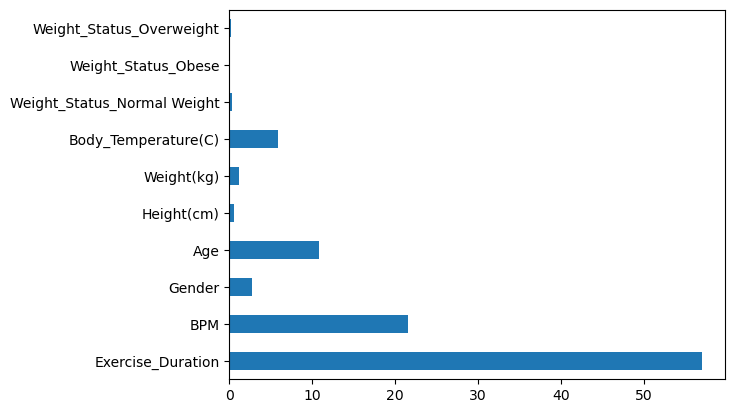

In [301]:
fi = pd.Series(model.feature_importances_)
fi.index = model.feature_names_
fi.plot.barh()

In [294]:
submission['Calories_Burned'] = y_pred

In [295]:
submission.to_csv('the_calorie_2차_catboost_gridsearch.csv')

331:	learn: 5.3242899	total: 1.53s	remaining: 3.09s
332:	learn: 5.2979172	total: 1.54s	remaining: 3.08s
333:	learn: 5.2739670	total: 1.54s	remaining: 3.08s
334:	learn: 5.2497415	total: 1.55s	remaining: 3.07s
335:	learn: 5.2257575	total: 1.55s	remaining: 3.06s
336:	learn: 5.1997866	total: 1.55s	remaining: 3.06s
337:	learn: 5.1737869	total: 1.55s	remaining: 3.04s
338:	learn: 5.1518378	total: 1.55s	remaining: 3.03s
339:	learn: 5.1252066	total: 1.56s	remaining: 3.02s
340:	learn: 5.1001090	total: 1.56s	remaining: 3.02s
341:	learn: 5.0751223	total: 1.56s	remaining: 3.01s
342:	learn: 5.0520821	total: 1.57s	remaining: 3s
343:	learn: 5.0303007	total: 1.57s	remaining: 2.99s
344:	learn: 5.0069220	total: 1.57s	remaining: 2.98s
345:	learn: 4.9843330	total: 1.57s	remaining: 2.98s
346:	learn: 4.9612782	total: 1.58s	remaining: 2.97s
347:	learn: 4.9384386	total: 1.58s	remaining: 2.96s
348:	learn: 4.9157983	total: 1.58s	remaining: 2.95s
349:	learn: 4.8955995	total: 1.58s	remaining: 2.94s
350:	learn: 4.8

524:	learn: 2.8816583	total: 2.32s	remaining: 2.1s
525:	learn: 2.8769155	total: 2.32s	remaining: 2.09s
526:	learn: 2.8709233	total: 2.32s	remaining: 2.08s
527:	learn: 2.8662434	total: 2.32s	remaining: 2.08s
528:	learn: 2.8607312	total: 2.32s	remaining: 2.07s
529:	learn: 2.8545558	total: 2.34s	remaining: 2.08s
530:	learn: 2.8491541	total: 2.35s	remaining: 2.07s
531:	learn: 2.8428331	total: 2.35s	remaining: 2.06s
532:	learn: 2.8376166	total: 2.35s	remaining: 2.06s
533:	learn: 2.8319968	total: 2.35s	remaining: 2.05s
534:	learn: 2.8276090	total: 2.35s	remaining: 2.04s
535:	learn: 2.8224684	total: 2.35s	remaining: 2.04s
536:	learn: 2.8178063	total: 2.36s	remaining: 2.03s
537:	learn: 2.8126657	total: 2.36s	remaining: 2.02s
538:	learn: 2.8068548	total: 2.36s	remaining: 2.02s
539:	learn: 2.8015771	total: 2.36s	remaining: 2.01s
540:	learn: 2.7971768	total: 2.36s	remaining: 2.01s
541:	learn: 2.7917116	total: 2.37s	remaining: 2s
542:	learn: 2.7871788	total: 2.37s	remaining: 1.99s
543:	learn: 2.78

5:	learn: 36.3432423	total: 14.2ms	remaining: 2.35s
6:	learn: 33.2070610	total: 28.6ms	remaining: 4.06s
7:	learn: 30.5085738	total: 36.6ms	remaining: 4.53s
8:	learn: 27.8827447	total: 62.9ms	remaining: 6.93s
9:	learn: 25.5516290	total: 64.2ms	remaining: 6.36s
10:	learn: 23.3466999	total: 65.4ms	remaining: 5.88s
11:	learn: 21.4111989	total: 68.5ms	remaining: 5.64s
12:	learn: 19.6066541	total: 81.4ms	remaining: 6.18s
13:	learn: 18.0581285	total: 83.7ms	remaining: 5.89s
14:	learn: 16.6086068	total: 86.6ms	remaining: 5.68s
15:	learn: 15.3391894	total: 88.5ms	remaining: 5.44s
16:	learn: 14.2146834	total: 91.1ms	remaining: 5.26s
17:	learn: 13.1079484	total: 93.1ms	remaining: 5.08s
18:	learn: 12.1277192	total: 95ms	remaining: 4.9s
19:	learn: 11.2375006	total: 97ms	remaining: 4.75s
20:	learn: 10.4282629	total: 99.4ms	remaining: 4.63s
21:	learn: 9.7178477	total: 101ms	remaining: 4.5s
22:	learn: 9.0803188	total: 104ms	remaining: 4.41s
23:	learn: 8.4847723	total: 107ms	remaining: 4.34s
24:	learn:

10:	learn: 23.2370350	total: 61.4ms	remaining: 5.52s
11:	learn: 21.2703116	total: 63.2ms	remaining: 5.21s
12:	learn: 19.4736852	total: 77.4ms	remaining: 5.87s
13:	learn: 17.9576444	total: 81.9ms	remaining: 5.76s
14:	learn: 16.5752876	total: 88.7ms	remaining: 5.82s
15:	learn: 15.2699964	total: 102ms	remaining: 6.27s
16:	learn: 14.0808215	total: 104ms	remaining: 6.03s
17:	learn: 12.9945910	total: 119ms	remaining: 6.48s
18:	learn: 12.0096036	total: 121ms	remaining: 6.25s
19:	learn: 11.2044453	total: 123ms	remaining: 6.02s
20:	learn: 10.3763390	total: 126ms	remaining: 5.86s
21:	learn: 9.6849727	total: 128ms	remaining: 5.67s
22:	learn: 9.0576237	total: 133ms	remaining: 5.64s
23:	learn: 8.4877938	total: 136ms	remaining: 5.51s
24:	learn: 7.9267073	total: 139ms	remaining: 5.41s
25:	learn: 7.4648792	total: 142ms	remaining: 5.31s
26:	learn: 7.0417587	total: 145ms	remaining: 5.24s
27:	learn: 6.6583991	total: 151ms	remaining: 5.25s
28:	learn: 6.2899548	total: 154ms	remaining: 5.15s
29:	learn: 6.00

818:	learn: 0.2886821	total: 4.34s	remaining: 960ms
819:	learn: 0.2881115	total: 4.35s	remaining: 954ms
820:	learn: 0.2878576	total: 4.35s	remaining: 948ms
821:	learn: 0.2872771	total: 4.35s	remaining: 942ms
822:	learn: 0.2870414	total: 4.35s	remaining: 936ms
823:	learn: 0.2866726	total: 4.35s	remaining: 930ms
824:	learn: 0.2863393	total: 4.36s	remaining: 924ms
825:	learn: 0.2859432	total: 4.38s	remaining: 923ms
826:	learn: 0.2857448	total: 4.38s	remaining: 917ms
827:	learn: 0.2853902	total: 4.38s	remaining: 911ms
828:	learn: 0.2850384	total: 4.39s	remaining: 905ms
829:	learn: 0.2848794	total: 4.39s	remaining: 899ms
830:	learn: 0.2844651	total: 4.41s	remaining: 897ms
831:	learn: 0.2839128	total: 4.41s	remaining: 891ms
832:	learn: 0.2837236	total: 4.41s	remaining: 885ms
833:	learn: 0.2829092	total: 4.42s	remaining: 879ms
834:	learn: 0.2826525	total: 4.43s	remaining: 876ms
835:	learn: 0.2824129	total: 4.43s	remaining: 870ms
836:	learn: 0.2821280	total: 4.44s	remaining: 864ms
837:	learn: 

243:	learn: 1.0002239	total: 1.27s	remaining: 3.94s
244:	learn: 0.9982887	total: 1.27s	remaining: 3.92s
245:	learn: 0.9946100	total: 1.27s	remaining: 3.9s
246:	learn: 0.9917788	total: 1.27s	remaining: 3.89s
247:	learn: 0.9877743	total: 1.28s	remaining: 3.87s
248:	learn: 0.9840915	total: 1.29s	remaining: 3.89s
249:	learn: 0.9807269	total: 1.29s	remaining: 3.87s
250:	learn: 0.9787414	total: 1.3s	remaining: 3.87s
251:	learn: 0.9766434	total: 1.3s	remaining: 3.85s
252:	learn: 0.9713221	total: 1.3s	remaining: 3.84s
253:	learn: 0.9691628	total: 1.3s	remaining: 3.82s
254:	learn: 0.9641484	total: 1.3s	remaining: 3.81s
255:	learn: 0.9621433	total: 1.33s	remaining: 3.85s
256:	learn: 0.9594656	total: 1.33s	remaining: 3.84s
257:	learn: 0.9562679	total: 1.33s	remaining: 3.83s
258:	learn: 0.9530289	total: 1.33s	remaining: 3.81s
259:	learn: 0.9504755	total: 1.33s	remaining: 3.8s
260:	learn: 0.9469202	total: 1.35s	remaining: 3.81s
261:	learn: 0.9443669	total: 1.35s	remaining: 3.8s
262:	learn: 0.942340

446:	learn: 3.5537045	total: 2.31s	remaining: 2.85s
447:	learn: 3.5428904	total: 2.31s	remaining: 2.84s
448:	learn: 3.5330373	total: 2.31s	remaining: 2.83s
449:	learn: 3.5240389	total: 2.34s	remaining: 2.86s
450:	learn: 3.5142383	total: 2.34s	remaining: 2.85s
451:	learn: 3.5049764	total: 2.35s	remaining: 2.85s
452:	learn: 3.4945474	total: 2.35s	remaining: 2.84s
453:	learn: 3.4858270	total: 2.35s	remaining: 2.83s
454:	learn: 3.4764795	total: 2.36s	remaining: 2.82s
455:	learn: 3.4669860	total: 2.36s	remaining: 2.81s
456:	learn: 3.4565739	total: 2.36s	remaining: 2.8s
457:	learn: 3.4470006	total: 2.36s	remaining: 2.79s
458:	learn: 3.4376848	total: 2.36s	remaining: 2.79s
459:	learn: 3.4280052	total: 2.37s	remaining: 2.78s
460:	learn: 3.4203551	total: 2.37s	remaining: 2.77s
461:	learn: 3.4117828	total: 2.44s	remaining: 2.84s
462:	learn: 3.4023728	total: 2.44s	remaining: 2.83s
463:	learn: 3.3932147	total: 2.44s	remaining: 2.82s
464:	learn: 3.3847398	total: 2.45s	remaining: 2.82s
465:	learn: 3

354:	learn: 0.7276835	total: 1.21s	remaining: 2.2s
355:	learn: 0.7262034	total: 1.21s	remaining: 2.19s
356:	learn: 0.7252502	total: 1.21s	remaining: 2.19s
357:	learn: 0.7234376	total: 1.22s	remaining: 2.18s
358:	learn: 0.7222812	total: 1.22s	remaining: 2.18s
359:	learn: 0.7217437	total: 1.22s	remaining: 2.17s
360:	learn: 0.7204687	total: 1.22s	remaining: 2.17s
361:	learn: 0.7199497	total: 1.23s	remaining: 2.16s
362:	learn: 0.7168432	total: 1.23s	remaining: 2.15s
363:	learn: 0.7151343	total: 1.23s	remaining: 2.15s
364:	learn: 0.7130041	total: 1.23s	remaining: 2.14s
365:	learn: 0.7109901	total: 1.23s	remaining: 2.14s
366:	learn: 0.7087197	total: 1.24s	remaining: 2.13s
367:	learn: 0.7082575	total: 1.24s	remaining: 2.13s
368:	learn: 0.7068437	total: 1.24s	remaining: 2.12s
369:	learn: 0.7049791	total: 1.24s	remaining: 2.12s
370:	learn: 0.7035801	total: 1.25s	remaining: 2.11s
371:	learn: 0.7014956	total: 1.25s	remaining: 2.11s
372:	learn: 0.7000289	total: 1.25s	remaining: 2.1s
373:	learn: 0.